# EP MAC0447 (2023) - Etapa 2
## Processamento, segmentação e aprendizado do classificador
#### César Júnior (n° USP 11275018)

Nesta etapa do projeto, iremos realizar o processamento e segmentação do conjunto de dados coletado na primeira etapa, com o intuito de treinar um classificador de imagens de objetos.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

import os

Definiremos, inicialmente, a seguinte classe auxiliar, para associar a imagem de cada objeto ao nome de sua classe.

In [70]:
class Object:
    def __init__(self, class_name, img, fname):
        self.class_name = class_name
        self.img = img
        self.fname = fname

Utilizaremos aqui imagens de dimensão $256 \times 256$.

In [71]:
H = 256

Carreguemos o conjunto de dados original, convertendo as imagens para níveis de cinza com o tamanho especificado acima:

In [72]:
original_gray_dataset = []

for subdir, _, files in os.walk('dataset'):
    for fname in files:
        class_name = subdir.partition('/')[2]
        img = cv2.imread(f"{subdir}/{fname}", cv2.IMREAD_GRAYSCALE)
        original_gray_dataset.append(Object(class_name, cv2.resize(img, (H, H)), fname))

### Data augmentation

Agora, realizaremos o passo de data augmentation. Para cada imagem do conjunto original, devemos gerar as seguintes imagens adicionais:
- Soma de fundo com gradiente de níveis de cinza;
- Logarítmo da imagem;
- Exponencial da imagem;
- Filtro da média implementado usando convolução.

Podemos definir o gradiente linear da seguinte forma:

In [73]:
linear_gradient = np.tile(np.linspace(0,1,H), (H,1))

Assim, podemos aplicar o gradiente à imagem através do produto de Hadamard entre as matrizes correspondentes.

Abaixo, definiermos o filtro de média, a ser aplicado nas imagens através de convolução. Utilizaremos um núcleo de tamanho $3 \times 3$.

In [74]:
MEAN_SZ = 3
mean_filter = np.tile(1/(MEAN_SZ**2), (MEAN_SZ, MEAN_SZ))

Assim, podemos definir a seguinte função de data augmentation, que, dada uma imagem do dataset, retorna as versões transformadas especificadas acima.

In [75]:
def augment_img(img):
    return [img,
            cv2.normalize((linear_gradient * img).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.normalize((np.log2(1 + img/255) * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.normalize(((2**(img/255) - 1) * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.filter2D(src=img, ddepth=-1, kernel=mean_filter)]

Então, obtemos o dataset aumentado aplicando a função acima a cada uma das imagens do dataset original.

In [76]:
augmented_dataset = []
for obj in original_gray_dataset:
    for aug_img in augment_img(obj.img):        
        augmented_dataset.append(Object(obj.class_name, aug_img, obj.fname))

Para visualizar o dataset aumentado, definamos a seguinte função, que gera a visualização MNIST das imagens passadas como parâmetro:

In [26]:
from mpl_toolkits.axes_grid1 import ImageGrid

def mnist(imgs, n_rows, n_cols, img_size, figsize=(20,15)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(n_rows, n_cols),
                     axes_pad=0.1, share_all=True)

    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    
    for ax, im in zip(grid, imgs):
        ax.imshow(cv2.resize(im, (img_size,img_size)), cmap='gray')

    plt.show()

Inicialmente, tínhamos as seguintes imagens em níveis de cinza:

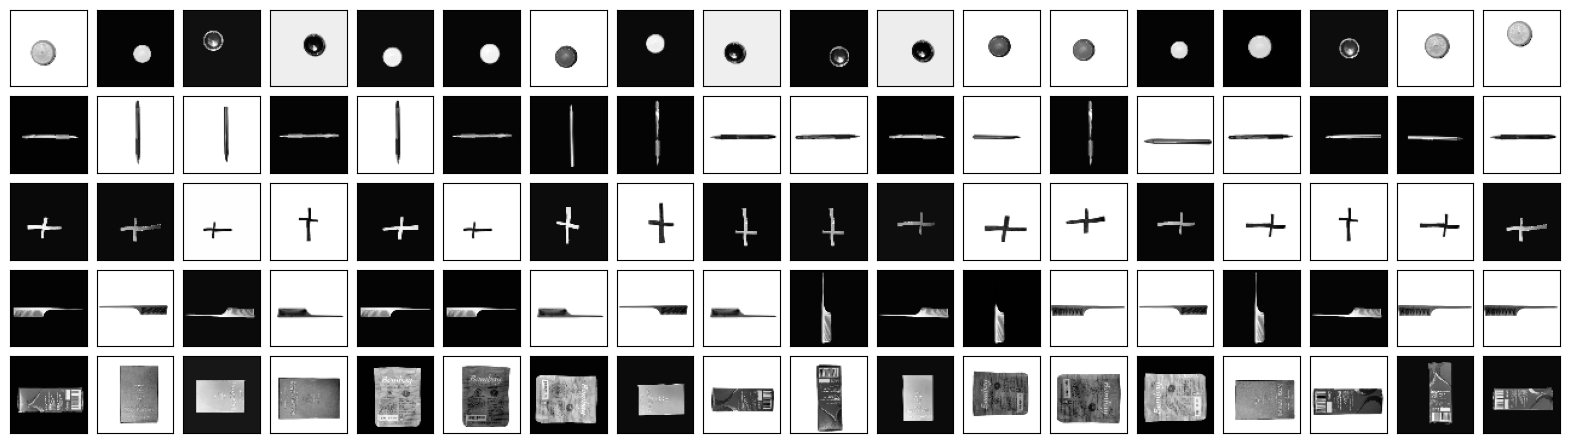

In [43]:
mnist([obj.img for obj in augmented_dataset[0::5]], 5, 18, 64)

Geramos, então, as seguintes imagens transformadas.

Soma de fundo com gradiente de níveis de cinza:

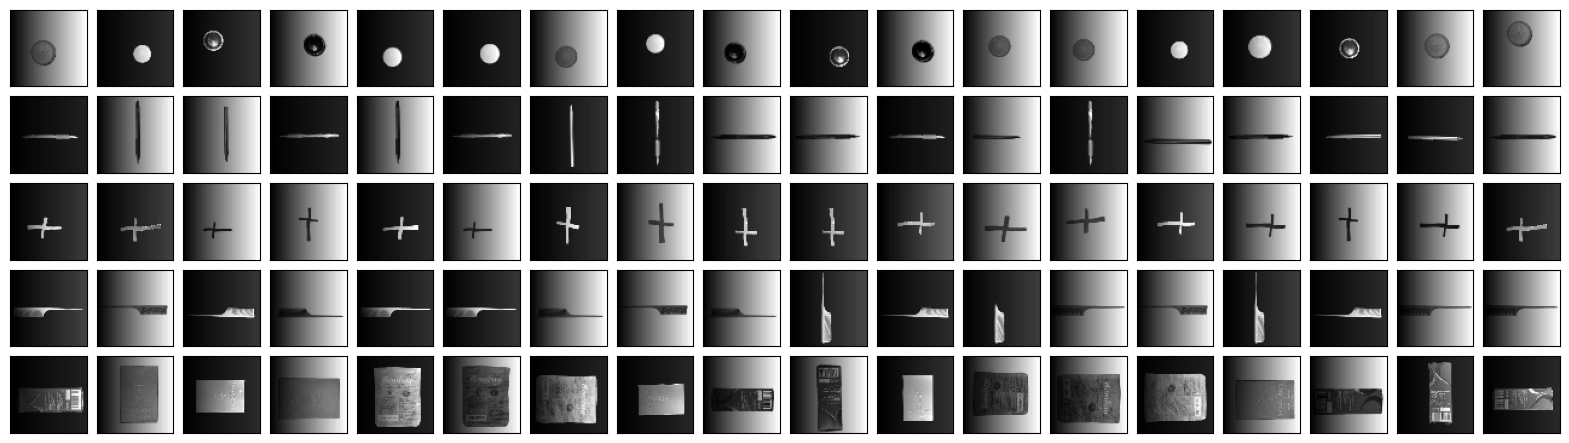

In [47]:
mnist([obj.img for obj in augmented_dataset[1::5]], 5, 18, 64)

Logarítmo das imagens:

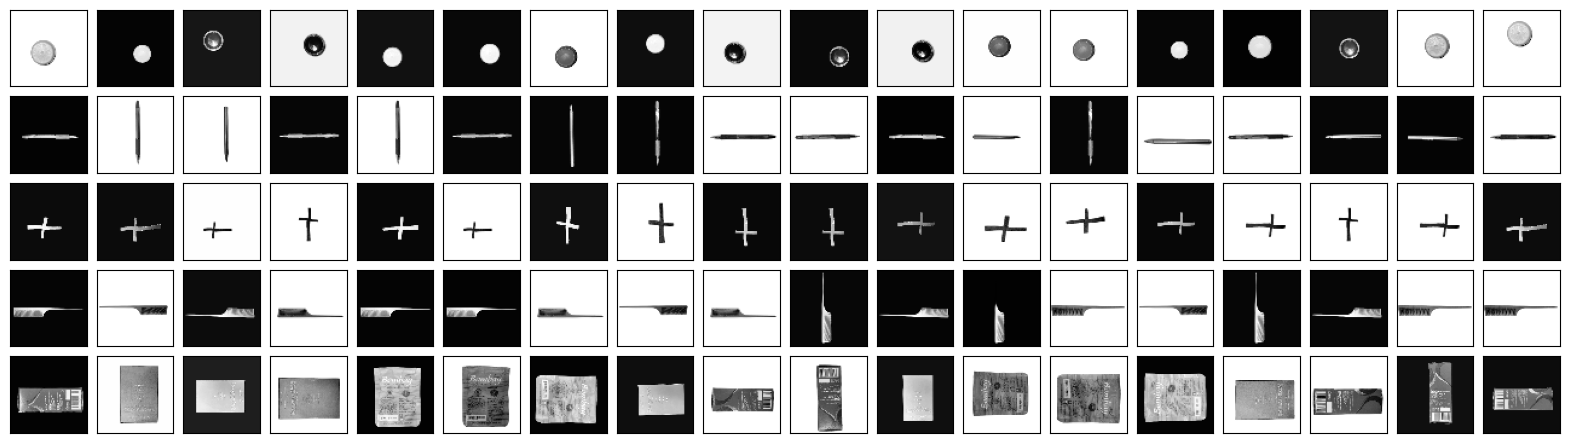

In [48]:
mnist([obj.img for obj in augmented_dataset[2::5]], 5, 18, 64)

Exponencial das imagens:

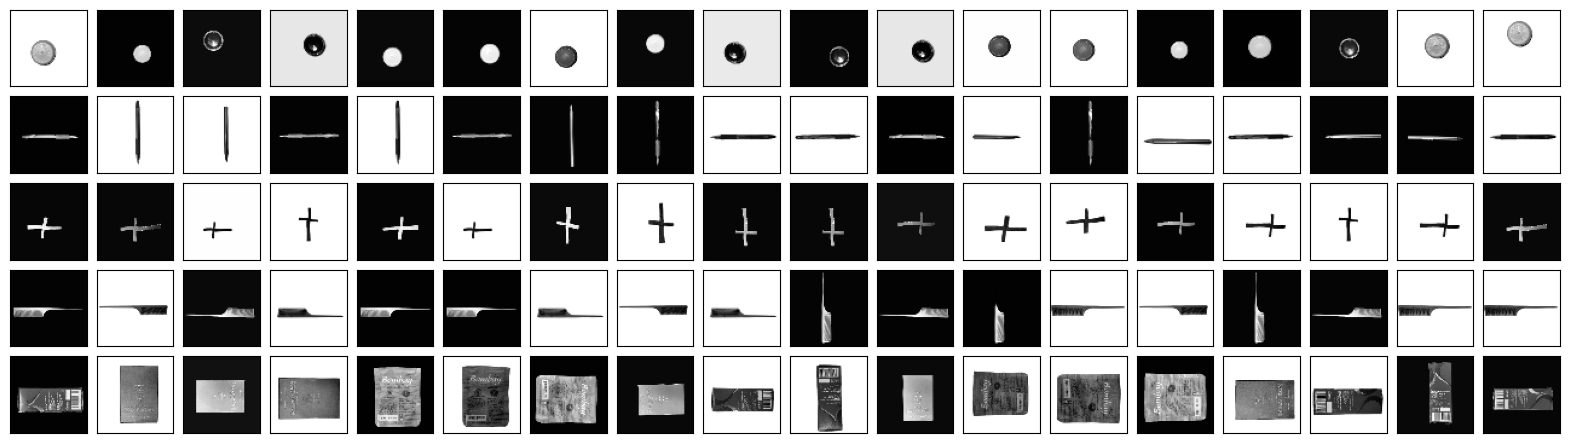

In [50]:
mnist([obj.img for obj in augmented_dataset[3::5]], 5, 18, 64)

Imagens após convolução com filtro de média:

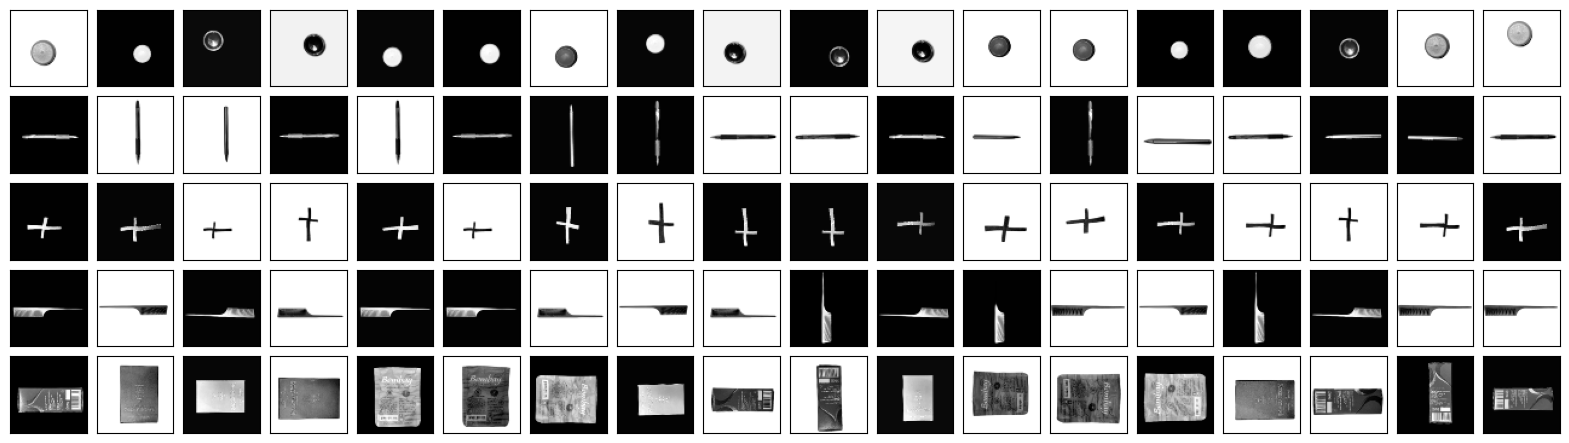

In [51]:
mnist([obj.img for obj in augmented_dataset[4::5]], 5, 18, 64)

### Normalização

Agora, normalizemos as imagens do dataset original. Para tanto, utilizaremos a equalização de histograma.

In [77]:
clahe = cv2.createCLAHE()
normalized_dataset = []
for obj in augmented_dataset:
    normalized_dataset.append(Object(obj.class_name, clahe.apply(obj.img), obj.fname))

### Segmentação

Obtido o dataset normalizado, podemos inicar o processo de segmentação.

Primeiramente, realizemos a binarização de cada uma das imagens. Para tanto, utilizaremos o algoritmo de thresholding de Otsu.

In [79]:
bin_dataset = []
for obj in normalized_dataset:
    _, thresh = cv2.threshold(cv2.GaussianBlur(obj.img, (11,11), 0), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    bin_dataset.append(Object(obj.class_name, thresh, obj.fname))

Em seguida, apliquemos um filtro de detecção de bordas nas imagens binarizadas. Desse modo, facilitaremos a posterior extração dos contornos. Para a detecção de bordas, utilizaremos o algoritmo de Canny.

In [81]:
edges_dataset = []
for obj in bin_dataset:
    edges = cv2.Canny(cv2.GaussianBlur(obj.img, (3,3), 0), threshold1=255/3, threshold2=255)
    edges_dataset.append(Object(obj.class_name, edges, obj.fname))

A partir das bordas, podemos extrair os contornos existentes nas imagens. Após extrair o contorno, aplicaremos as operações morfológicas de dilatação e fechamento para cobrir pequenos pontos de descontinuidade nos contornos.

In [82]:
contour_dataset = []
for obj in edges_dataset:
    new_img = np.zeros_like(obj.img)
    contour, _ = cv2.findContours(obj.img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contour:
        cv2.drawContours(new_img, [cnt], 0, 255, -1)
    
    rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilation = cv2.dilate(new_img, rect, iterations=2)
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, rect)

    contour_dataset.append(Object(obj.class_name, closing, obj.fname))

Finalmente, podemos obter uma segmentação do conjunto de dados selecionando o contorno de área máxima e preenchendo-o (já que nenhuma dos objetos originais contém buracos).

In [83]:
seg_dataset = []

for obj in contour_dataset:
    new_img = np.zeros_like(obj.img)
    contour, _ = cv2.findContours(obj.img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    
    cnt = max(contour, key=cv2.contourArea)
    cv2.drawContours(new_img, [cnt], 0, 255, -1)
    
    new_obj = Object(obj.class_name, new_img, obj.fname)
    seg_dataset.append((new_obj, cnt))

Assim, temos o dataset segmentado:

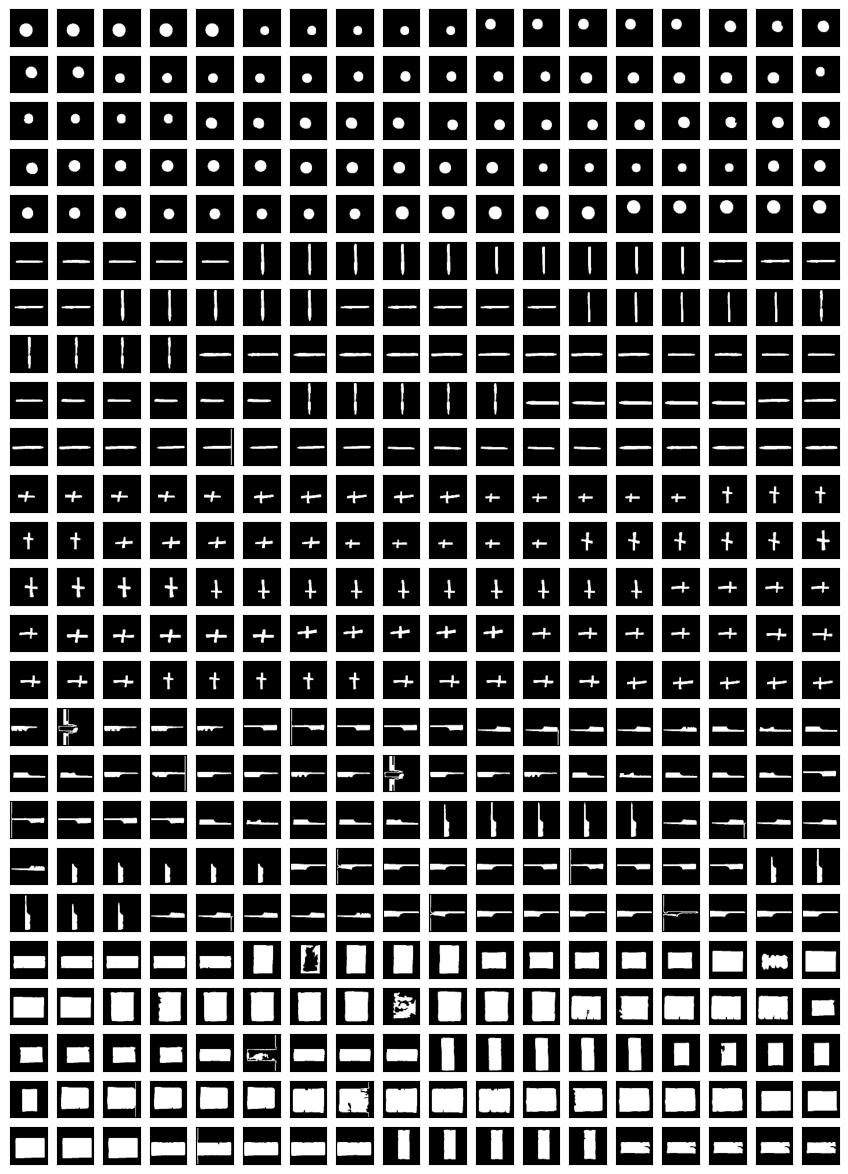

In [59]:
mnist([obj[0].img for obj in seg_dataset], 5*5, 18, 64)

Podemos observar que os resultados obtidos correspondem ao esperado para a maioria das imagens. No entanto, o processo falhou para uma pequena quantidade de imagens. Em particular, `Caixa` e `Pente` foram as classes mais problemáticas. Podemos comparar os resultados obtidos com a ground truth obtida manualmente, como será realizado posteriormente.

### Extração de Feret Box

A partir das imagens segmentadas, torna-se trivial a obtenção das Feret boxes.

Dada uma imagem segmentada, o vértice superior esquerdo da Feret box é da forma $(x_0,y_0)$, onde $x_0$ é a primeira linha para a qual temos um pixel com valor não-nulo, e $y_0$ é a primeira coluna com pixel de valor não-nulo. Analogamente, o vértice inferior direito é da forma $(x_1,y_1)$, correspondendo, respectivamente, à ultima linha e última coluna com pixel de valor não-nulo.

Então, podemos definir a seguinte função para obter os vértices da Feret box de uma imagem segmentada:

In [61]:
def get_feret_box(img_seg):
    x_in, y_in = np.where(img_seg == 255)
    box_min = (min(y_in), min(x_in))
    box_max = (max(y_in), max(x_in))

    return box_min, box_max

Podemos, então, aplicar a função definida acima a cada uma das imagens segmentadas, e desenhar na correspondente imagem do dataset aumentado a Feret box obtida.

In [62]:
feret_box_imgs = []
for i in range(len(augmented_dataset)):
    img_copy = cv2.cvtColor(augmented_dataset[i].img, cv2.COLOR_GRAY2RGB)
    box_min, box_max = get_feret_box(seg_dataset[i][0].img)
    cv2.rectangle(img_copy, box_min, box_max, (255,0,0), thickness=2)
    feret_box_imgs.append(img_copy)

Abaixo, temos, algumas das Feret boxes obtidas:

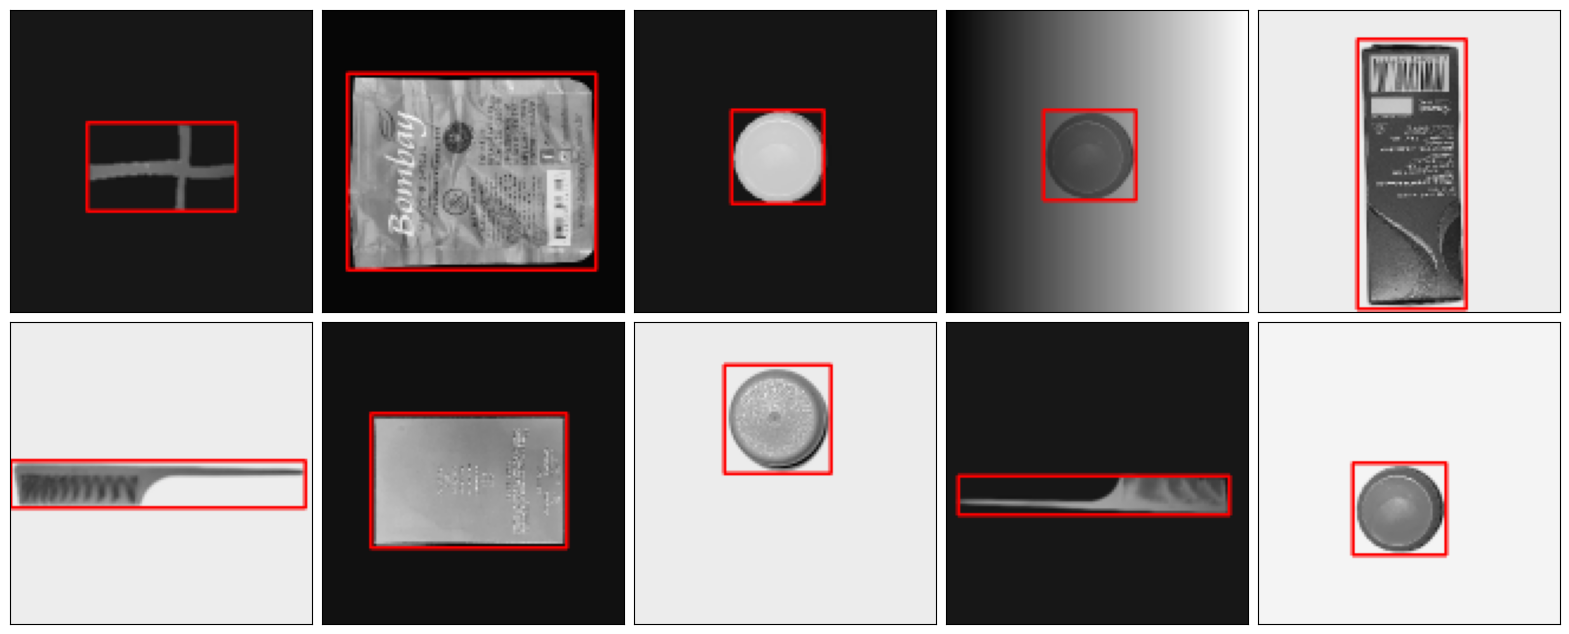

In [69]:
idxs = np.random.randint(0, len(feret_box_imgs), size=10)
mnist([feret_box_imgs[i] for i in idxs], 2, 5, 128)

Podemos comparar as Feret boxes obtidas a partir segmentação automática com aquelas obtidas a partir da ground truth.

### Comparação entre resultados e ground truth

Inicialmente, carreguemos as imagens de ground truth, no mesmo formato que as imagens em nível de cinza originais:

In [84]:
ground_truth = []

for subdir, _, files in os.walk('ground_truth'):
    for fname in files:
        class_name = subdir.partition('/')[2]
        img = cv2.imread(f"{subdir}/{fname}", cv2.IMREAD_GRAYSCALE)
        ground_truth.append(Object(class_name, cv2.resize(img, (H, H)), fname))

Para medir a similaridade entre a ground truth e a segmentação obtida, podemos simplesmente computar a proporção de pontos diferentes entre as duas imagens, como na função a seguir:

In [103]:
def seg_dist(seg, gt):
    return np.sum(seg != gt)/(H**2)

Então, podemos comparar as ground truths com as respectivas segmentações obitdas:

In [110]:
seg_diff = []
for gt in ground_truth:
    seg = next((s[0].img for s in seg_dataset if s[0].fname == gt.fname), None)
    seg_diff.append(seg_dist(seg, gt.img))

In [114]:
print('Dif. média:', np.mean(seg_diff))
print('Desvio padrão:', np.std(seg_diff))
print('Dif. mínima:', np.min(seg_diff))
print('Dif. máxima:', np.max(seg_diff))

Dif. média: 0.06478712293836805
Desvio padrão: 0.1280861063797649
Dif. mínima: 0.0123291015625
Dif. máxima: 0.4267120361328125


Podemos observar que, em média, as ground truths correspondem quase totalmente com os resultados obtidos. No entanto, como esperávamos, obtivemos alguns valores de diferença mais altos:

In [108]:
ground_truth[np.argmax(diff)].fname

'Caixa_Caixa1_Claro_1.jpg'

Assim como esperávamos, a classe `Caixa` foi problemática. Talvez possamos explicar esse resultado pelo alto brilho das imagens dessa classe no dataset original.

Para comparar as Feret boxes, podemos realizar um procedimento similar. Podemos medir a diferença entre as Feret boxes da ground truth e da segmentação obtida como a média entre as distâncias de seus respectivos vértices:

In [109]:
def box_dist(seg, gt):
    seg_min, seg_max = get_feret_box(seg)
    gt_min, gt_max = get_feret_box(gt)

    min_dist = np.linalg.norm(np.array(seg_min) - np.array(gt_min))
    max_dist = np.linalg.norm(np.array(seg_max) - np.array(gt_max))

    return (min_dist + max_dist)/2

In [112]:
box_diff = []
for gt in ground_truth:
    seg = next((s[0].img for s in seg_dataset if s[0].fname == gt.fname), None)
    box_diff.append(box_dist(seg, gt.img))

In [115]:
print('Dif. média:', np.mean(box_diff))
print('Desvio padrão:', np.std(box_diff))
print('Dif. mínima:', np.min(box_diff))
print('Dif. máxima:', np.max(box_diff))

Dif. média: 6.275519019877596
Desvio padrão: 4.849919790278371
Dif. mínima: 2.58113883008419
Dif. máxima: 19.61106134616343


Novamente, observamos que o resultado obtido é satisfatório. Dessa vez, não obtivemos outliers significativos.

### Extração de features

A partir dos contornos obtidos no passo anterior, podemos extrair as features a serem passadas para o classificador.

Escolhemos utilizar as seguintes features:
- Centroide normalizado (i.e., distância entre o centroide e o centro da forma);
- Área da forma normalizada pela area do retângulo de área mínima que delimita a forma. Esse retângulo é similar à Feret box, mas pode estar rotacionado para minimizar sua área;
- Área da forma normalizada pela área do círculo de raio mínimo que delimita a forma. Similarmente à Feret box, esse é o círculo com centro correspondente ao centro da imagem que contenha todos os pixels da forma, de modo que seu raio seja mínimo;
- Alongamento da forma, i.e., o maior valor entre as razões $w/h$ e $h/w$, onde $w$ e $h$ correspondem, respectivamente, à largura e altura do retângulo de área mínima que delimita a forma.

O centroide normalizado atuará, naturalmente, como uma medida de assimetria da imagem. As áreas normalizadas pelo retângulo e círculo medirão, respectivamente, o quão próxima a forma é de um retângulo e um círculo. No caso de coincidência perfeita, a medida respectiva será 1. O alongamento é auto-explicativo.

Escolhemos extrair essas features por elas serem capazes (e suficientes) para distinguir cada uma das classes de objetos que temos. Note, também, que todas essas features são invariantes em relação à rotação das formas.

Abaixo, definimos uma função que extrai as features descritas acima a partir de um contorno:

In [147]:
def get_features(cnt):
    area = cv2.contourArea(cnt)

    M = cv2.moments(cnt)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    area_norm_box = area/cv2.contourArea(box)

    (x,y), r = cv2.minEnclosingCircle(cnt)
    area_norm_circle = area/(np.pi * r**2)

    cx_norm = abs(cx - x)
    cy_norm = abs(cy - y)
    
    w, h = rect[1]
    stretch = max(w/h, h/w)

    return area_norm_box, area_norm_circle, cx_norm, cy_norm, stretch

Agora, podemos aplicar a extração de features a cada um dos contornos obtidos na segmentação do dataset. Nesse mesmo passo, já criaremos um dicionário associando cada classe aos respectivos features de objetos, para facilitar o processo de treinamento do classificador posteriormente.

In [157]:
objs_per_class = {}

for i in range(len(seg_dataset)):
    obj = seg_dataset[i]
    if not objs_per_class.get(obj[0].class_name):
        objs_per_class[obj[0].class_name] = []
    objs_per_class[obj[0].class_name].append(get_features(obj[1]))

### Treinamento do classificador

Obtidas as features de cada uma das imagens do dataset, podemos iniciar o processo de treinamento de um classificador.
Inicialmente, dividiremos aleatoriamente o conjunto de dados original em subconjuntos de treinamento e teste. Nesse passo, tomaremos o cuidado de, apesar da aleatoriedade, incluir o mesmo número de objetos de cada classe no conjunto de treino.

Escolhemos utilizar 20% do conjunto de dados para teste.

In [158]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = [], [], [], []

for class_name in objs_per_class.keys():
    objs = objs_per_class[class_name]
    
    X_tr, X_te, y_tr, y_te = train_test_split(
        objs, [class_name] * len(objs), 
        test_size=test_size, shuffle=True, 
        random_state=42)

    X_train += X_tr
    X_test += X_te
    y_train += y_tr
    y_test += y_te

Podemos, então, embaralhar os conjuntos construídos:

In [159]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Escolhemos como classificador o modelo de árvore de decisão. Essa é uma escolha razoável para esse projeto, já que as classes de objetos que estamos utilizando podem ser facilmente distinguidas a partir das features que extraímos. Além disso, esse é um modelo bastante leve.

In [166]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

A seguir, utilizamos o modelo treinado para predição sobre o conjunto de teste. 

In [167]:
y_pred = clf.predict(X_test)

Podemos avaliar o resultado obtido através de um classification report, associado à matriz de confusão, que comparam as predições com os resultados esperados.

In [169]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Caixa       1.00      1.00      1.00        18
      Caneta       0.95      1.00      0.97        18
        Cruz       1.00      1.00      1.00        18
       Pente       1.00      0.94      0.97        18
       Tampa       1.00      1.00      1.00        18

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



In [170]:
confusion_matrix(y_test, y_pred)

array([[18,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0],
       [ 0,  0, 18,  0,  0],
       [ 0,  1,  0, 17,  0],
       [ 0,  0,  0,  0, 18]])

Podemos observar que o modelo foi altamente preciso. A princípio, a acurárcia muito alta pode ser fonte de preocupação de overfitting. No entanto, as features que extraímos do contorno realmente são capazes de facilmente distinguir as classes de objetos, então podemos considerar razoável a performance do modelo.

A única classe para a qual o modelo apresentou alguma dificuldade foi a dos pentes.

Por fim, podemos exportar o modelo treinado para ser utilizado no aplicativo de classificação.

In [171]:
from joblib import dump
dump(clf, 'clf.joblib')

['clf.joblib']